In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [328]:
train_data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')

In [329]:
train_df = pd.DataFrame(train_data)
train_df.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [330]:
train_df = train_df.drop('id', axis = 1)
train_df.head()

,Date,Open,Close,Volume,Strategy
0,2015-06-01,66.208486,75.609978,298506300,Hold
1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2015-06-15,47.701942,71.140831,250670900,Buy
3,2015-06-22,54.754816,72.881344,223614300,Hold
4,2015-06-29,48.031899,66.284718,406814900,Buy


In [331]:
target_column_1 = train_df["Close"]

In [332]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [333]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index(['Date'],inplace=True)

In [334]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler to your data and transform the column
train_df["Open"] = scaler.fit_transform(train_df[['Open']])
train_df["Volume"] = scaler.fit_transform(train_df[['Volume']])

In [335]:
train_df['Difference'] = train_df["Volume"]*train_df["Open"]

In [336]:
train_df['Difference_2'] = train_df["Volume"] + 2*train_df["Open"]

In [337]:
train_df["Difference"].corr(train_df["Close"])

0.3617153059812325

In [338]:
(train_df["Volume"]).corr(train_df["Difference"])

-0.6949553641678058

In [339]:
train = train_df.iloc[0:(len(train_df)-30)]
test = train_df.iloc[len(train):(len(train_df)-1)]

In [340]:
train_df

,Open,Close,Volume,Strategy,Difference,Difference_2
Date,,,,,,
2015-06-01,-0.579331,75.609978,1.447614,Hold,-0.838647,0.288953
2015-06-08,-0.668474,74.443331,0.643359,Hold,-0.430069,-0.693589
2015-06-15,-1.367832,71.140831,0.902158,Buy,-1.234000,-1.833506
2015-06-22,-1.067333,72.881344,0.593637,Hold,-0.633609,-1.541028
2015-06-29,-1.353773,66.284718,2.682634,Buy,-3.631678,-0.024913
...,...,...,...,...,...,...
2021-01-25,0.063021,83.373498,-0.618851,Sell,-0.039001,-0.492809
2021-02-01,-0.333841,85.294903,0.069583,Sell,-0.023230,-0.598100
2021-02-08,-0.341750,83.266453,-0.291342,Hold,0.099566,-0.974842


<Axes: xlabel='Date'>

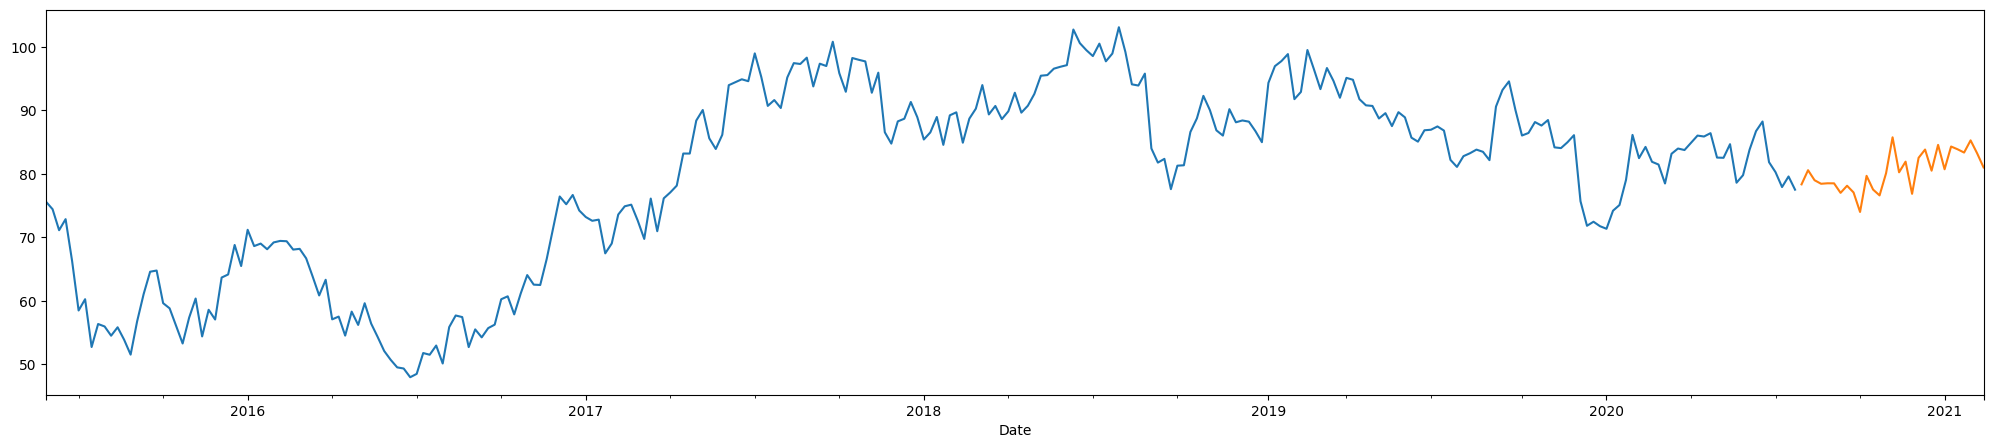

In [341]:
train['Close'].plot(figsize=(25,5))
test['Close'].plot(figsize=(25,5))

In [342]:
t = sm.tsa.adfuller(train.Close, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.693547
p-value                          0.434440
#Lags Used                       1.000000
Number of Observations Used    268.000000
dtype: float64

In [343]:
train['differenced_values'] = train['Close'].diff(1)
train.dropna(inplace=True)

In [344]:
t = sm.tsa.adfuller(train.differenced_values, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -1.801047e+01
p-value                        2.715644e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.680000e+02
dtype: float64

In [19]:
s = sm.tsa.seasonal_decompose(train.Close, period=12)

<Axes: xlabel='Date'>

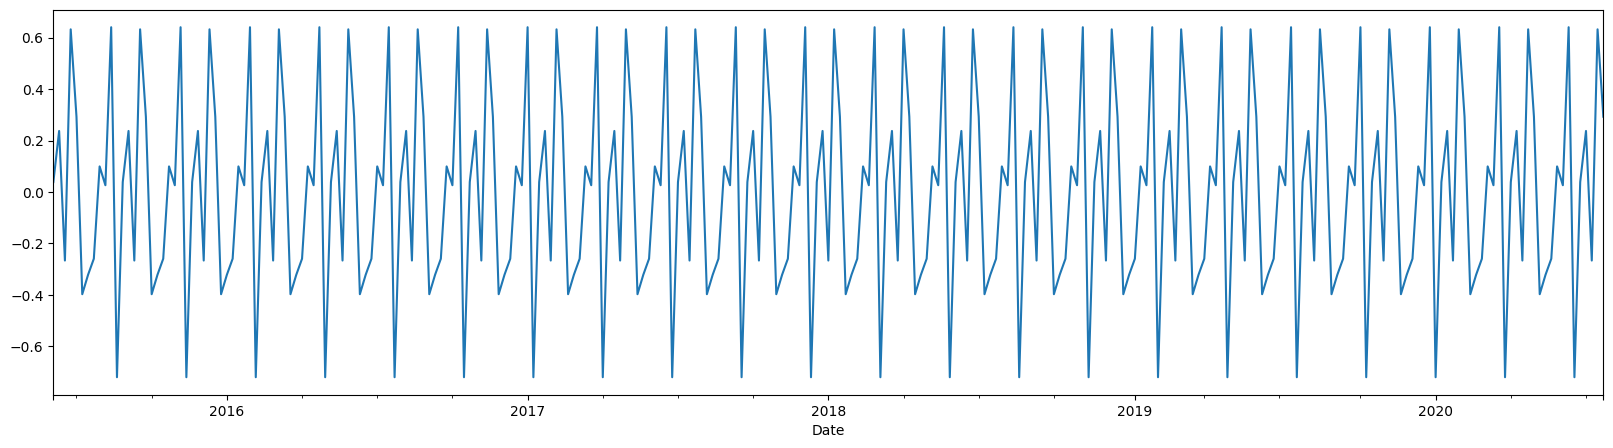

In [20]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='Date'>

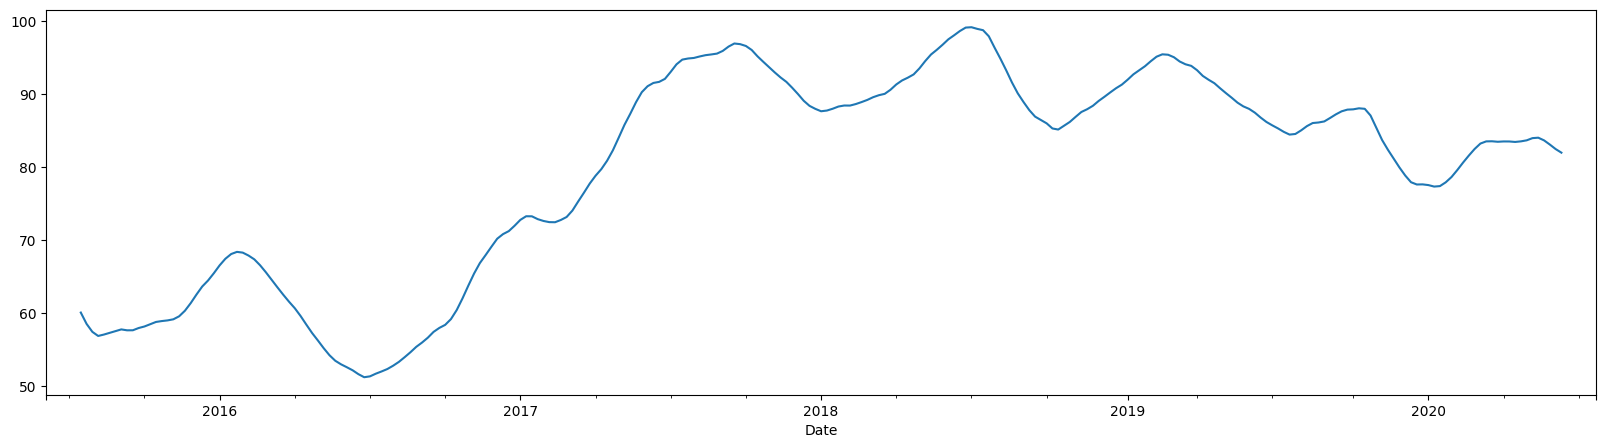

In [21]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='Date'>

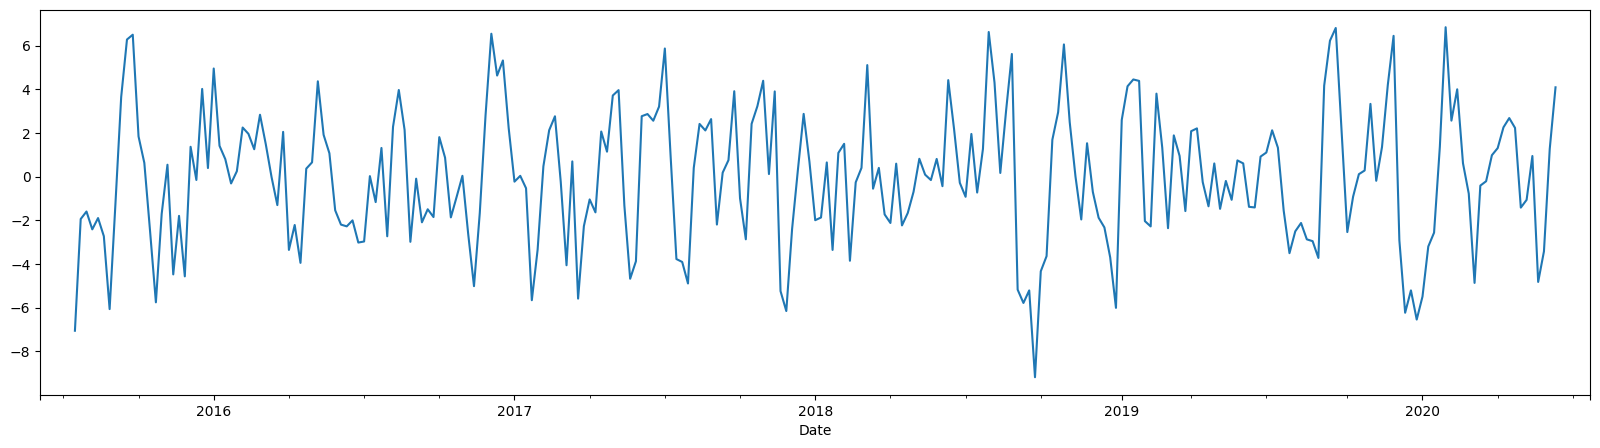

In [22]:
s.resid.plot(figsize=(20,5))

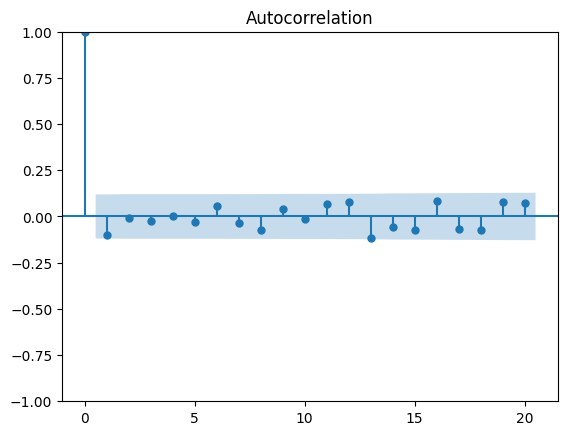

In [24]:
import matplotlib.pyplot as plt
plot_acf(train.differenced_values,lags=20)
plt.show()

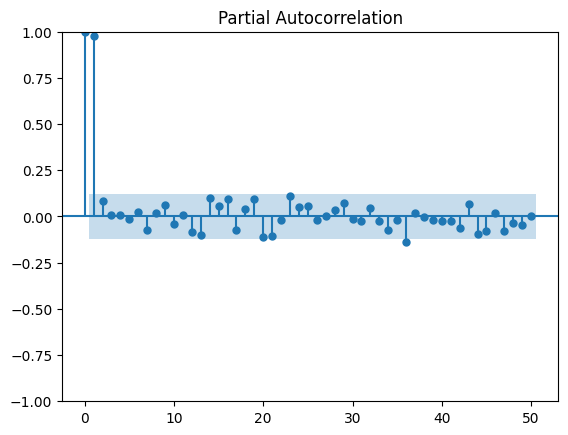

In [25]:
plot_pacf(train.Close,lags=50)
plt.show()

In [26]:
import warnings
warnings.filterwarnings("ignore")

import itertools
p=q=range (0,8)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.Close, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic
              #print(param, model_arima_fit.aic)
       except:
              continue

sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))

In [345]:
print(sorted_dict)

{(7, 0, 3): 108.72780392176914, (5, 1, 6): 1398.3357124011459, (6, 1, 5): 1399.0608055341581, (6, 1, 4): 1400.4489001592722, (0, 1, 1): 1400.6447508894553, (1, 1, 0): 1400.74700771358, (2, 1, 5): 1400.976194933008, (0, 1, 0): 1401.477401419301, (1, 1, 1): 1402.4979419999504, (2, 1, 6): 1402.5665344161612, (0, 1, 2): 1402.5764197373837, (2, 1, 0): 1402.6389833781896, (6, 1, 6): 1402.7690315743696, (5, 1, 2): 1402.8901656056335, (3, 1, 5): 1403.151772019612, (5, 1, 3): 1403.5592276599239, (2, 1, 1): 1403.690417775732, (1, 1, 2): 1403.7001823284759, (3, 1, 4): 1404.2056841032966, (0, 1, 3): 1404.351676020994, (3, 1, 0): 1404.380626949932, (6, 1, 7): 1404.436221534765, (4, 1, 3): 1404.5655230976129, (4, 1, 7): 1404.8337793122578, (6, 1, 3): 1404.9285351722199, (4, 1, 5): 1405.590567174435, (3, 1, 1): 1405.6899152721596, (5, 1, 4): 1405.8451311022282, (7, 1, 2): 1406.1032151529118, (2, 1, 2): 1406.164040625787, (2, 1, 7): 1406.1889713640549, (1, 1, 3): 1406.2780345313172, (0, 1, 4): 1406.31

In [346]:
endog = train['Close']
exog = sm.add_constant(train[['Difference', 'Difference_2']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,0,3))
model_fit = mod.fit()
model_fit.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67426D+00    |proj g|=  1.03301D+00

At iterate    5    f=  3.31569D+00    |proj g|=  7.62518D-02

At iterate   10    f=  3.11882D+00    |proj g|=  1.86022D-01

At iterate   15    f=  2.85806D+00    |proj g|=  3.92875D-01

At iterate   20    f=  2.63153D+00    |proj g|=  7.67632D-02

At iterate   25    f=  2.58621D+00    |proj g|=  4.63460D-02

At iterate   30    f=  2.58320D+00    |proj g|=  6.96868D-03

At iterate   35    f=  2.58249D+00    |proj g|=  3.42963D-03

At iterate   40    f=  2.57960D+00    |proj g|=  1.54358D-01

At iterate   45    f=  2.57223D+00    |proj g|=  3.79240D-02

At iterate   50    f=  2.57154D+00    |proj g|=  8.30811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  269
Model:               SARIMAX(7, 0, 3)   Log Likelihood                -691.744
Date:                Wed, 01 Nov 2023   AIC                           1411.489
Time:                        12:39:45   BIC                           1461.815
Sample:                    06-08-2015   HQIC                          1431.700
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           82.3831      7.935     10.383      0.000      66.831      97.935
Difference      -0.5652      0.237     -2.383      0.017      -1.030      -0.100
Difference_2    -0.6488      0.202     -3.206      0.001      -1.045      -0.252
ar.L1            0.3380      0.916      0.369      0.712      -1.457       2.133
ar.L2            0.7065      0.439      1.609      0.108      -0.154       1.567
ar.L3            0.7111      0.327      2.178      0.029       0.071       1.351
ar.L4           -0.6918      0.944     -0.733      0.464      -2.542       1.158
ar.L5           -0.0807      0.124     -0.651      0.515      -0.324       0.162
ar.L6            0.0314      0.085      0.369      0.712      -0.135       0.198
ar.L7           -0.0308      0.073     -0.422      0.673      -0.174       0.112
ma.L1            0.5854      0.907      0.646      0.518      -1.191       2.362
ma.L2           -0.1195      1.264     -0.094      0.925      -2.597       2.358
ma.L3           -0.7923      0.912     -0.869      0.385      -2.580       0.995
sigma2           9.8937      1.109      8.923      0.000       7.721      12.067
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.93   Prob(JB):                         0.95
Heteroskedasticity (H):               0.94   Skew:                            -0.01
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

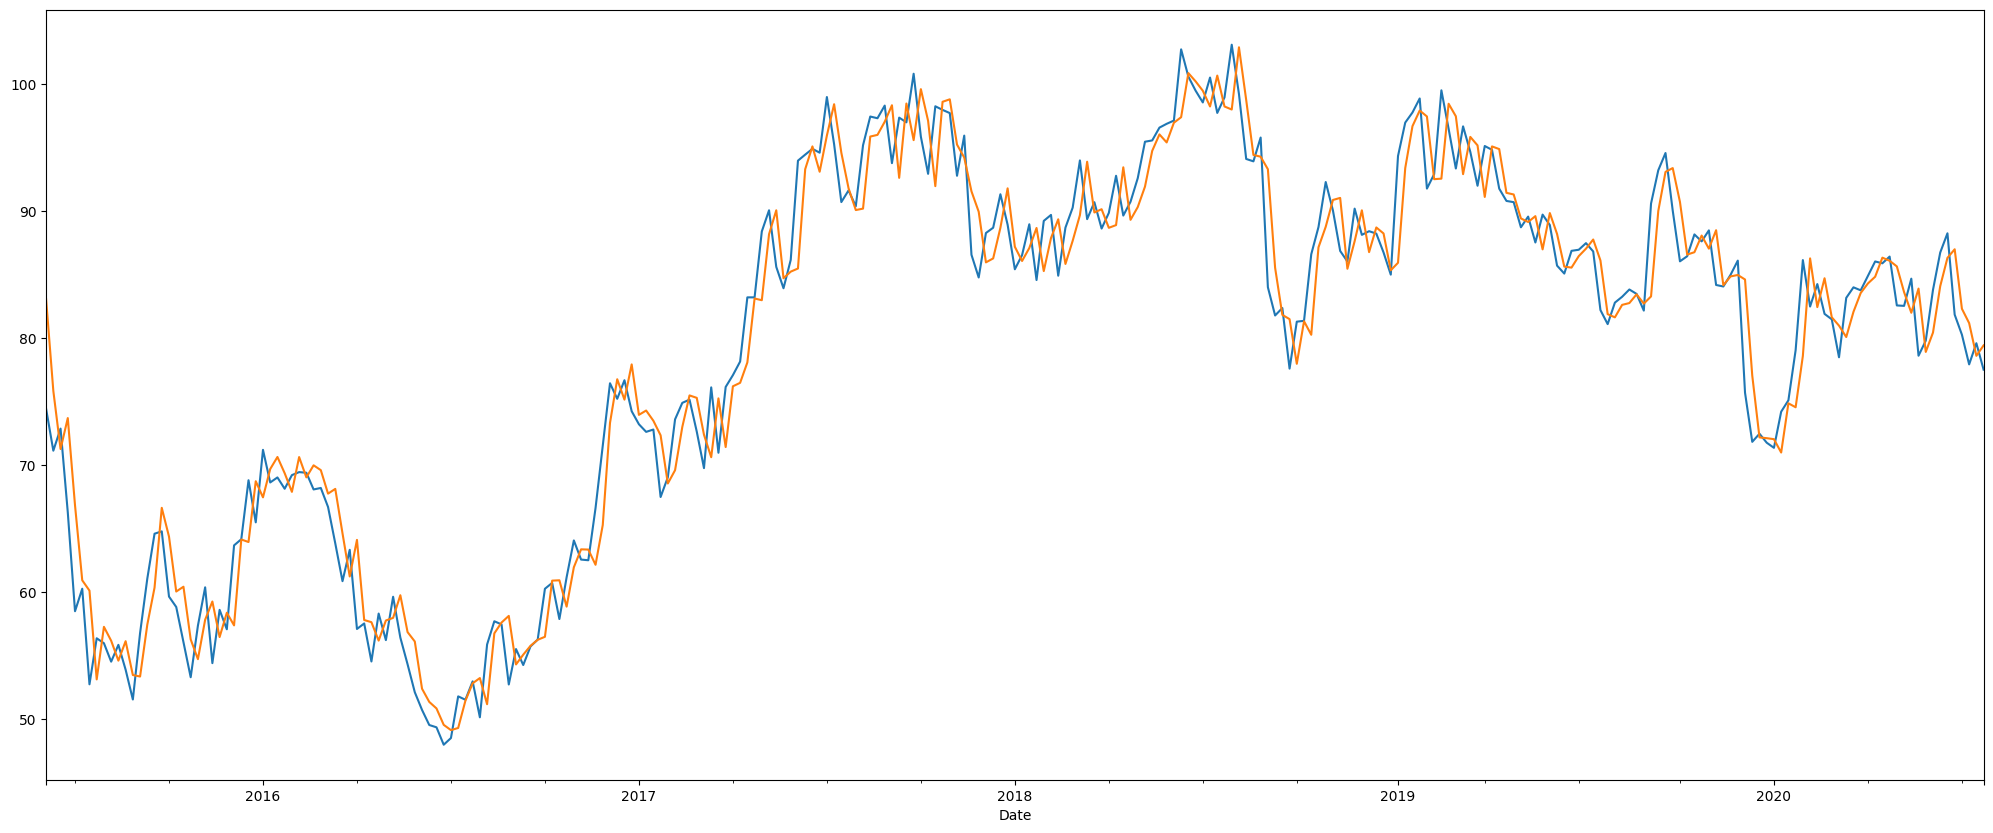

In [347]:
train['Close'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [348]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['Difference','Difference_2']]))
test['predicted'] = predict.values
test.tail(5)

,Open,Close,Volume,Strategy,Difference,Difference_2,predicted
Date,,,,,,,
2021-01-18,0.036559,83.889750,-0.505207,Sell,-0.018470,-0.432089,79.458823
2021-01-25,0.063021,83.373498,-0.618851,Sell,-0.039001,-0.492809,79.578115
2021-02-01,-0.333841,85.294903,0.069583,Sell,-0.023230,-0.598100,79.769747
2021-02-08,-0.341750,83.266453,-0.291342,Hold,0.099566,-0.974842,79.959790
2021-02-15,-0.444530,81.026827,-0.043229,Hold,0.019216,-0.932288,80.081757


In [349]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
MAE = mean_absolute_error(test["Close"], test["predicted"])
RMSE = math.sqrt(mean_squared_error(test["Close"], test["predicted"]))
print("MAE:", MAE)
print("RMSE:", RMSE)
print("MSE:", RMSE**2)

MAE: 2.6449948088914854
RMSE: 3.273812755893677
MSE: 10.717849960652153


In [159]:
train_df

,Open,Close,Volume,Strategy,Difference,Difference_2
Date,,,,,,
2015-06-01,-0.579331,75.609978,1.447614,Hold,-0.838647,0.288953
2015-06-08,-0.668474,74.443331,0.643359,Hold,-0.430069,-0.693589
2015-06-15,-1.367832,71.140831,0.902158,Buy,-1.234000,-1.833506
2015-06-22,-1.067333,72.881344,0.593637,Hold,-0.633609,-1.541028
2015-06-29,-1.353773,66.284718,2.682634,Buy,-3.631678,-0.024913
...,...,...,...,...,...,...
2021-01-25,0.063021,83.373498,-0.618851,Sell,-0.039001,-0.492809
2021-02-01,-0.333841,85.294903,0.069583,Sell,-0.023230,-0.598100
2021-02-08,-0.341750,83.266453,-0.291342,Hold,0.099566,-0.974842


In [350]:
target_column_2 = train_df["Strategy"]

In [351]:
cols = pd.concat([train_df.iloc[:, 0:3],train_df["Difference"], train_df["Difference_2"]], join = 'outer', axis = 1)
cols

,Open,Close,Volume,Difference,Difference_2
Date,,,,,
2015-06-01,-0.579331,75.609978,1.447614,-0.838647,0.288953
2015-06-08,-0.668474,74.443331,0.643359,-0.430069,-0.693589
2015-06-15,-1.367832,71.140831,0.902158,-1.234000,-1.833506
2015-06-22,-1.067333,72.881344,0.593637,-0.633609,-1.541028
2015-06-29,-1.353773,66.284718,2.682634,-3.631678,-0.024913
...,...,...,...,...,...
2021-01-25,0.063021,83.373498,-0.618851,-0.039001,-0.492809
2021-02-01,-0.333841,85.294903,0.069583,-0.023230,-0.598100
2021-02-08,-0.341750,83.266453,-0.291342,0.099566,-0.974842


In [352]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cols, target_column_2, test_size = 0.2, random_state = 0)

In [353]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=150, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

In [354]:
y_class_pred = classifier.predict(X_test)

In [355]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_class_pred)

0.6

In [356]:
test_data = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')

In [357]:
test_df = pd.DataFrame(test_data)

In [358]:
test_df = test_df.drop('id', axis = 1)
test_df.iloc[:, 1:3] = sc.fit_transform(test_df.iloc[:, 1: 3])

In [359]:
test_df

,Date,Open,Volume
0,2021-03-01,0.272530,0.143479
1,2021-03-08,0.339740,0.284158
2,2021-03-15,0.038493,-0.788253
3,2021-03-22,-0.001004,-0.060988
4,2021-03-29,-0.223829,0.389571
...,...,...,...
95,2022-12-26,-1.474171,0.471190
96,2023-01-02,-1.081431,-0.369220
97,2023-01-09,-0.983596,-0.275558
98,2023-01-16,-1.652739,-0.601721


In [360]:
test_df['Difference'] = test_df["Volume"]*test_df["Open"]

In [361]:
test_df['Difference_2'] = test_df["Volume"] + 2*test_df["Open"]

In [362]:
predict = model_fit.predict(start = 0,end = len(test_df) - 1,exog = sm.add_constant(test_df[['Difference','Difference_2']]))
test_df['Close'] = predict.values
test_df.tail(5)

,Date,Open,Volume,Difference,Difference_2,Close
95,2022-12-26,-1.474171,0.471190,-0.694615,-2.477153,76.212465
96,2023-01-02,-1.081431,-0.369220,0.399286,-2.532082,76.487036
97,2023-01-09,-0.983596,-0.275558,0.271038,-2.242750,78.094000
98,2023-01-16,-1.652739,-0.601721,0.994488,-3.907199,83.128584
99,2023-01-23,-1.478598,-0.319395,0.472257,-3.276591,82.994757


In [363]:
cols_test = pd.concat([test_df["Open"], test_df["Close"], test_df["Volume"], test_df["Difference"], test_df["Difference_2"]], join = 'outer', axis = 1)

In [364]:
test_class_pred = classifier.predict(cols_test)

In [365]:
test_class_pred

array(['Buy', 'Sell', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold', 'Sell',
       'Buy', 'Sell', 'Hold', 'Buy', 'Hold', 'Buy', 'Hold', 'Hold',
       'Sell', 'Sell', 'Hold', 'Buy', 'Sell', 'Hold', 'Hold', 'Hold',
       'Hold', 'Sell', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold',
       'Sell', 'Hold', 'Buy', 'Sell', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Sell', 'Hold', 'Hold', 'Buy', 'Buy', 'Sell', 'Sell',
       'Sell', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold'], dtype=object)

In [366]:
date = test_df["Date"]

In [367]:
submission_df = pd.DataFrame()
submission_df["Date"] = date

In [368]:
submission_df["Close"] = test_df["Close"]

In [369]:
submission_df

,Date,Close
0,2021-03-01,83.076227
1,2021-03-08,75.851716
2,2021-03-15,71.270976
3,2021-03-22,73.708775
4,2021-03-29,66.841011
...,...,...
95,2022-12-26,76.212465
96,2023-01-02,76.487036
97,2023-01-09,78.094000
98,2023-01-16,83.128584


In [370]:
submission_df["Strategy"] = test_class_pred

In [371]:
submission_df.to_csv('submission.csv', index = False)